<a href="https://colab.research.google.com/github/benihime91/pytorch_examples/blob/master/00_ExperimentLog.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import warnings

warnings.filterwarnings("ignore")

In [ ]:
# install required dependencies for google colab
# !pip install --upgrade seaborn albumentations fastcore pytorch_lightning

# Task 2

## Part - 1
> Use this dataset (https://www.dropbox.com/s/pan6mutc5xj5kj0/trainPart1.zip) to train a CNN. Use no other data source or pretrained networks, and explain your design choices during preprocessing, model building and training. Also, cite the sources you used to borrow techniques. A test set will be provided later to judge the performance of your classifier. Please save your model checkpoints.

Let's us first download the given dataset.

In [5]:
import os

os.makedirs("Data")

In [7]:
!wget -P "Data/" https://www.dropbox.com/s/pan6mutc5xj5kj0/trainPart1.zip
!unzip --qq "Data/trainPart1.zip" -d "Data/"

--2021-04-04 05:31:15--  https://www.dropbox.com/s/pan6mutc5xj5kj0/trainPart1.zip
Resolving www.dropbox.com (www.dropbox.com)... 162.125.6.18, 2620:100:601c:18::a27d:612
Connecting to www.dropbox.com (www.dropbox.com)|162.125.6.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/pan6mutc5xj5kj0/trainPart1.zip [following]
--2021-04-04 05:31:16--  https://www.dropbox.com/s/raw/pan6mutc5xj5kj0/trainPart1.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucf09ec34583bf4b9f91d6974280.dl.dropboxusercontent.com/cd/0/inline/BL_R5b9y7qEdo6ZtqpQLy3haF6VE4x5DWa9jxRTmSsjJc_qNrGklsYdjJpy-PkwmfmsR5dKB-OHo1qAo9NyD5YNS_MnmWaitihnt1Gqg-WFCAyQdnjXICMsvJcCYs4XoCum6OhMrQMB8QIr_lCEnyo-k/file# [following]
--2021-04-04 05:31:16--  https://ucf09ec34583bf4b9f91d6974280.dl.dropboxusercontent.com/cd/0/inline/BL_R5b9y7qEdo6ZtqpQLy3haF6VE4x5DWa9jxRTmSsjJc_qNrGklsYdjJpy-PkwmfmsR5dKB-OHo1qAo9NyD

### Analyzing the Dataset
> In this part we will analyze the get familiar with the given dataset.

In [8]:
# imports
import os
import random
from typing import *

import matplotlib.pyplot as plt
import pandas as pd
from fastcore.all import *
from torchvision.datasets.folder import IMG_EXTENSIONS

pd.set_option("display.max_colwidth", None)

In [11]:
DATASET_01_PATH = Path("Data/train/")
DATASET_01_PATH.ls()

(#62) [Path('Data/train/Sample022'),Path('Data/train/Sample049'),Path('Data/train/Sample042'),Path('Data/train/Sample014'),Path('Data/train/Sample024'),Path('Data/train/Sample061'),Path('Data/train/Sample004'),Path('Data/train/Sample005'),Path('Data/train/Sample033'),Path('Data/train/Sample020')...]

To make the data exploration easy I will store the datapaths and their labels into a pandas datataframe and then we will proceed from there.

In [12]:
def folder2df(directory: Union[str, Path], extensions: list = IMG_EXTENSIONS,
              shuffle: bool = False, seed: int = 42):
    """
    Parses all the Images in `directory` and puts them in a `DataFrame` object.
    """

    random.seed(seed)

    image_list = L()
    target_list = L()

    if not isinstance(directory, Path):
        directory = Path(directory)

    for label in directory.ls():
        label = Path(label)
        if os.path.isdir(label):
            for img in label.ls():
                if str(img).lower().endswith(extensions):
                    image_list.append(img)
                    target_list.append(str(label).split(os.path.sep)[-1])

    print(f"Found {len(image_list)} files belonging to {len(set(target_list))} classes.")

    dataframe: pd.DataFrame = pd.DataFrame()
    dataframe["image_id"] = image_list.map(str)
    dataframe["target"] = target_list
    if shuffle:
        dataframe = (dataframe.sample(frac=1, random_state=seed)
                     .reset_index(inplace=False, drop=True))
    return dataframe

In [13]:
DATASET_01_DF = folder2df(directory=DATASET_01_PATH, shuffle=True)
DATASET_01_DF.head()

Found 2480 files belonging to 62 classes.


,image_id,target
0,Data/train/Sample006/img006-021.png,Sample006
1,Data/train/Sample004/img004-036.png,Sample004
2,Data/train/Sample058/img058-025.png,Sample058
3,Data/train/Sample015/img015-003.png,Sample015
4,Data/train/Sample049/img049-004.png,Sample049


In [14]:
unq_cls = DATASET_01_DF.target.unique()
tot_itm = len(DATASET_01_DF)
print("Total number of Images in the Dataset: ", tot_itm)
print("Number of unique classes in the Dataset: ",len(unq_cls))

Total number of Images in the Dataset:  2480
Number of unique classes in the Dataset:  62


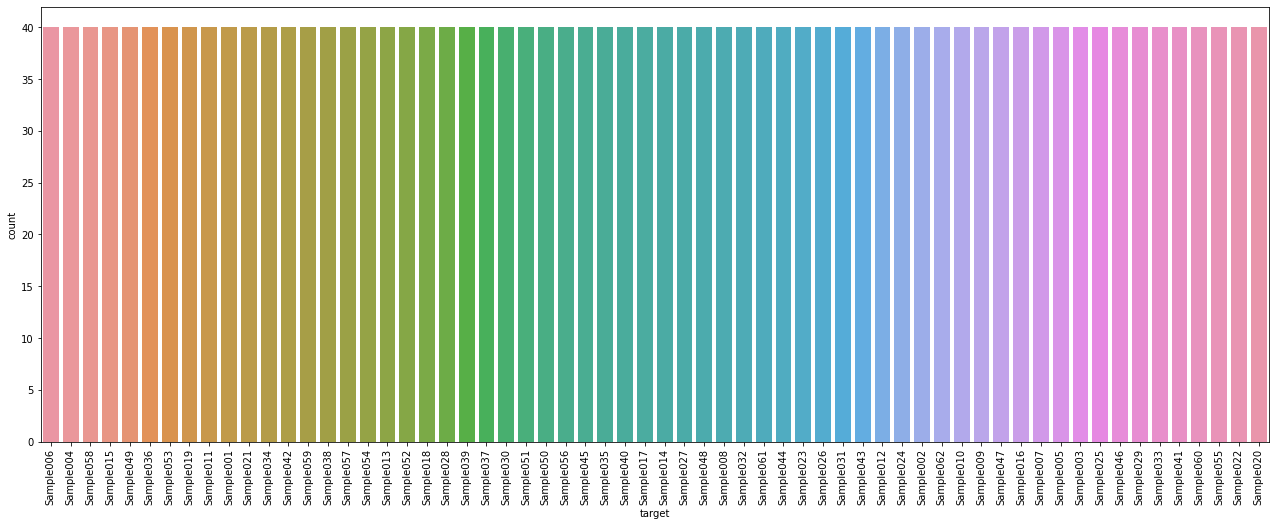

In [15]:
import seaborn as sns

_, ax = plt.subplots(1, 1, figsize=(22, 8))
sns.countplot(data=DATASET_01_DF, x="target", ax=ax);
plt.xticks(rotation=90);

The distibution across all the classes is exactly same. This is a good thing because in this way our model will be less prone to overfitting for a prticular class.

Let's view images from the dataset :

In [16]:
import torch
from torchvision.io import read_image
from torchvision.utils import make_grid

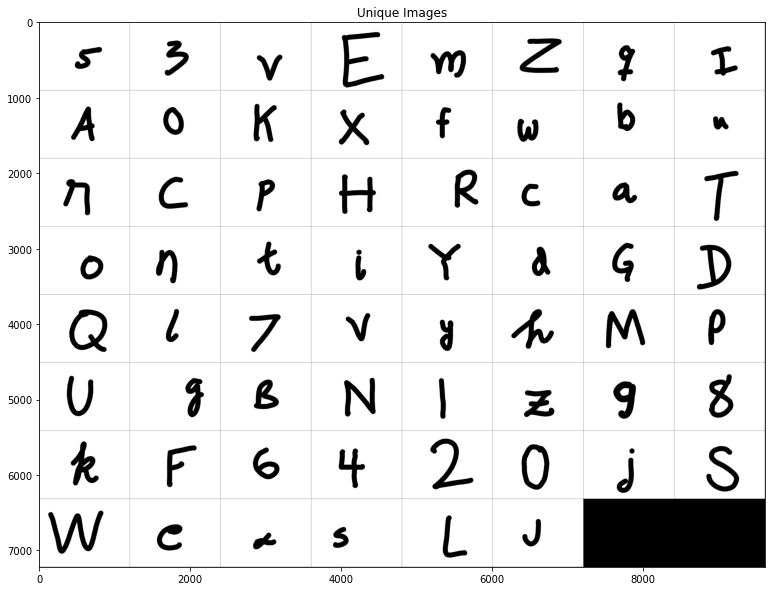

In [17]:
unq_ims = L()

for c in unq_cls:
    unq_series = DATASET_01_DF.loc[DATASET_01_DF["target"] == c].reset_index(drop=True, inplace=False)
    im_path = unq_series["image_id"][0]
    unq_ims.append(read_image(im_path))
    
unq_ims = torch.stack([o for o in unq_ims])

grid = make_grid(unq_ims).permute(1, 2, 0)
fig = plt.figure(figsize=(13, 13))
plt.imshow(grid) 
plt.title("Unique Images");

> Before feeding the images into a CNN we need to normalize the images. Data Normalization insures that each input parameter pixel has a similar data distribution. This makes convergence faster while training the network.

> Now the above dataset is almost similar to the MNIST dataset. So instead of manually calculating the channel mean and std for normalizing the images, I will use the precomputed values for `mean`, `std` for `MNIST Dataset`.

In [18]:
MEAN, STD = [0.15, 0.15, 0.15], [0.15, 0.15, 0.15]

### Creating the Dataset 

Since, in this task in am going to be using `PyTorch`, before we can directly start training the `CNN network`, we need to get our data into `Dataset` and `DataLoader`.

In [19]:
import torchvision.transforms as T
from PIL import Image
from torch.utils.data import DataLoader, Dataset

We also need to encode our string labels into interger labels.

In [21]:
from functools import partial

from sklearn.preprocessing import LabelEncoder

In [22]:
encoder = LabelEncoder()

encoder.fit(unq_cls)

def encode_label(x):
    "Encoder `x`, given x is a scalar value"
    return encoder.transform([x]).item()

# DATASET_01_CLASS_MAP = L(list(encoder.classes_)).map_dict(encode_label)
# DATASET_01_CLASS_MAP = {k:v for v, k in DATASET_01_CLASS_MAP.items()}

DATASET_01_DF["cat_label"] = DATASET_01_DF["target"].map(encode_label)
DATASET_01_DF.head()

,image_id,target,cat_label
0,Data/train/Sample006/img006-021.png,Sample006,5
1,Data/train/Sample004/img004-036.png,Sample004,3
2,Data/train/Sample058/img058-025.png,Sample058,57
3,Data/train/Sample015/img015-003.png,Sample015,14
4,Data/train/Sample049/img049-004.png,Sample049,48


Let's also create a Training and Validation split on the data.

Why we need a different training and validation split for the data ?
> This is so that we don't inadvertently overfit, train a model to work well only on our training data. For this purpose we will compute metric over on the validation data. During the training phase the model will see only the training data. The Validation data will remain separate and will only be used for calculation of the *metric*. 

In [23]:
from sklearn.model_selection import train_test_split

TRAIN_DATASET_01, VALID_DATASET_01 = train_test_split(DATASET_01_DF, 
                                                      test_size=0.2, random_state=42, 
                                                      shuffle=True, stratify=DATASET_01_DF['cat_label'])

TRAIN_DATASET_01 = TRAIN_DATASET_01.reset_index(drop=True, inplace=False)
VALID_DATASET_01 = VALID_DATASET_01.reset_index(drop=True, inplace=False) 

Now we will create a custom `Dataset` obj that can parse the data.

In [24]:
class Dataset_01(Dataset):
    def __init__(self, df:pd.DataFrame, transforms: T.Compose = None):
        self._dataframe  = df
        self._transforms = transforms
    
    @property
    def transforms(self):
        return self._transforms
        
    def __len__(self):
        return len(self._dataframe)
    
    def __getitem__(self, idx):
        im = self._dataframe['image_id'][idx]
        im = Image.open(im)
        
        if self._transforms is not None:
            im = self._transforms(im)
        
        lbl = self._dataframe["cat_label"][idx]   
        return im, lbl

Before we instante the dataset we will also need to preprocess the images. For that i will `Torchvision.Transforms`,
initially for the BaseLine model, I will only convert the images to tensors & apply normalization. I will also resize the images to `64x64` image sizes. This will ensure that the shape of all the images are same.

Why `64x64` ?
> Since this seems like a fairly simple task i will first experiment will smaller images and then if it requires I will increase the image dimensions.

On a later section we will explore more advanced data augmentation techniques.

In [51]:
IMG_SIZE = 64

base_tfms = T.Compose([
    T.Resize((IMG_SIZE, IMG_SIZE)),
    T.CenterCrop((IMG_SIZE, IMG_SIZE)),
    T.ToTensor(),
    T.Normalize(torch.tensor(MEAN), torch.tensor(STD)),
    T.Grayscale(num_output_channels=3),
])

def get_loaders():
    # instantiate the dataset set obj
    train_ds = Dataset_01(df=TRAIN_DATASET_01, transforms=base_tfms)
    valid_ds = Dataset_01(df=VALID_DATASET_01, transforms=base_tfms)

    # create the dataloaders obj
    train_dl = DataLoader(train_ds, batch_size=32, num_workers=num_cpus(), shuffle=True) 
    valid_dl = DataLoader(valid_ds, batch_size=32, num_workers=num_cpus(), shuffle=False)
    return train_dl, valid_dl


train_dl, valid_dl = get_loaders()

View the Datasets for Sanity Check -

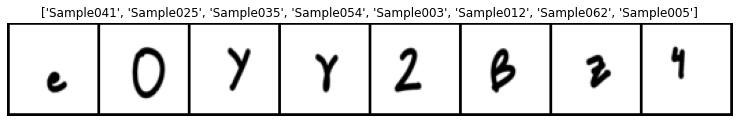

In [52]:
ims, lbls = next(iter(train_dl))
ims, lbls = ims[:8], lbls[:8]

grid = make_grid(ims, normalize=True).permute(1, 2, 0)
fig = plt.figure(figsize=(13, 13))
plt.imshow(grid) 
plt.title([encoder.inverse_transform([o]).item() for o in lbls.data.cpu().numpy()])
plt.axis("off");

In [53]:
del train_dl, valid_dl

### Baseline
First I will let's start by making a good baseline Model and subsequently we will experiment by improving upon this model.

Let's first create the building blocks that we will use building our network.

In [54]:
import math

import torch.nn.functional as F
from torch import nn, optim


def get_same_padding(x: int, k: int, s: int, d: int):
    """
    Calculate asymmetric TensorFlow-like 'SAME' padding for a convolution i.e., 
    if you use a stride of 1, the layer's outputs will have the same spatial dimensions as its inputs.
    
    
    Source: https://github.com/rwightman/pytorch-image-models/blob/de9dff933a503e357e1d6a6cf157831f25cebb8a/timm/models/layers/padding.py#L12
    """
    return max((math.ceil(x / s) - 1) * s + (k - 1) * d + 1 - x, 0)

In [76]:
class ConvBnDropBlock(nn.Sequential):
    "Create sequence of convolutional, Activation, `BatchNorm` & Drouput layers."
    def __init__(self, in_chans, out_chans, kernel_size, stride=1, dilation=1, 
                 padding = "same", bias=True, input_sz: Optional = None, 
                 act_cls: Callable = nn.ReLU, p_drop=0.0, use_bn=True,):
        
        if padding == "same":
            assert input_sz is not None, "input_sz is needed for same padding"
        
        layers = []
        
        if padding == "same":
            padding = get_same_padding(input_sz, kernel_size, stride, dilation)
        
        conv_layer = nn.Conv2d(in_chans, out_chans, kernel_size, stride, 
                               dilation=dilation, padding=padding, bias=bias)
        
        if act_cls is not None:
            act_layer = act_cls(inplace=True)
        else:
            act_layer = nn.Identity()
        if use_bn:
            norm_layer = nn.BatchNorm2d(out_chans)
        else:
            norm_layer = nn.Identity()
           
        layers += [conv_layer, act_layer, norm_layer]
        
        if p_drop > 0.0:
            layers.append(nn.Dropout2d(p=p_drop))
            
        super(ConvBnDropBlock, self).__init__(*layers)

For training i will be using `pytorch-lightning`, So let's first convert the whole pytorch model in Lightning format. So let's build our model in `pytorch-lightning` format.

In [56]:
from collections import OrderedDict

import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint
from torchmetrics import Accuracy

from third_party import NotebookProgressCallback

pl.seed_everything(42)

Global seed set to 42


42

For evaluating the model initially I will use the `Accuracy` metric and for loss function i will use the standart `CrossEntropy Loss` from PyTorch.

The baseline model used in this task is inpired from : https://www.kaggle.com/cdeotte/how-to-choose-cnn-architecture-mnist

In [58]:
class BaseLineCnn(pl.LightningModule):
    def __init__(self, input_sz: int, num_classes: int, lr: float):
        super().__init__()
        self.save_hyperparameters()
        
        self.net = self.build_network()
        
        self.loss_fn = nn.CrossEntropyLoss(reduction="mean")
        self.metric = Accuracy()
        self.tst_metric = Accuracy()
        
    def build_network(self):
        conv1 = ConvBnDropBlock(input_sz=self.hparams.input_sz, in_chans=3, out_chans=32, 
                                kernel_size=3, p_drop=0, padding="same", stride=1, act_cls=nn.ReLU)        
        
        conv2 = ConvBnDropBlock(input_sz=self.hparams.input_sz, in_chans=32, out_chans=32, 
                                kernel_size=3, p_drop=0, padding="same", stride=1, act_cls=nn.ReLU)        
        
        conv3 = ConvBnDropBlock(input_sz=self.hparams.input_sz, in_chans=32, out_chans=32, 
                                kernel_size=5, p_drop=0.4, padding="same", stride=2, act_cls=nn.ReLU)
        
        block1 = nn.Sequential(conv1, conv2, conv3)
        
        conv4 = ConvBnDropBlock(input_sz=self.hparams.input_sz, in_chans=32, out_chans=64, 
                                kernel_size=3, p_drop=0, padding="same", stride=1, act_cls=nn.ReLU)        
        
        conv5 = ConvBnDropBlock(input_sz=self.hparams.input_sz, in_chans=64, out_chans=64, 
                                kernel_size=3, p_drop=0, padding="same", stride=1, act_cls=nn.ReLU)       
        
        conv6 = ConvBnDropBlock(input_sz=self.hparams.input_sz, in_chans=64, out_chans=64, 
                                kernel_size=5, p_drop=0.4, padding="same", stride=2, act_cls=nn.ReLU)
        
        block2 = nn.Sequential(conv4, conv5, conv6)
        
        global_pool  = nn.Sequential(OrderedDict(pool_layer=nn.AdaptiveAvgPool2d(1), flatten=nn.Flatten()))
        
        fc1 = nn.Sequential(nn.Linear(64, 128), nn.ReLU(inplace=True), nn.BatchNorm1d(128), nn.Dropout(0.4))
        fc2 = nn.Linear(in_features=128, out_features=self.hparams.num_classes)
        
        ls = OrderedDict(block1=block1, block2=block2, global_pool=global_pool, fc1=fc1, fc2=fc2)
        return nn.Sequential(ls)
        
    def forward(self, xb):
        return self.net(xb)
    
    def training_step(self, batch, batch_idx, *args, **kwargs):
        images, labels = batch
        # 1. Forward pass:
        logits = self.forward(images)
        # 2. Compute loss:
        loss = self.loss_fn(logits, labels)
        
        self.log_dict(dict(train_loss=loss))
        return loss
    
    def validation_step(self, batch, batch_idx, *args, **kwargs):
        images, labels = batch
        logits = self.forward(images)
        # 1. Forward pass:
        logits = self.forward(images)
        # 2. Compute loss:
        loss = self.loss_fn(logits, labels)
        # 3. Compute accuracy:
        acc = self.metric(F.softmax(logits), labels)
        self.log_dict(dict(val_loss=loss, val_acc=acc), on_epoch=True)
        
    def test_step(self, batch, batch_idx, *args, **kwargs):
        images, labels = batch
        logits = self.forward(images)
        # 1. Forward pass:
        logits = self.forward(images)
        # 2. Compute accuracy:
        acc = self.tst_metric(F.softmax(logits), labels)
        self.log_dict(dict(test_acc=acc))
        
    def configure_optimizers(self):
        parameters = list(self.parameters())
        trainable_parameters = list(filter(lambda p: p.requires_grad, parameters))
        opt_func = optim.Adam(trainable_parameters, lr=self.hparams.lr)
        return [opt_func]

In [59]:
# make a directory to store the checkpoints
# os.makedirs("Checkpoints/", exist_ok=True)

Train the model initially for 20 epochs and view preformance -

In [60]:
model = BaseLineCnn(input_sz=IMG_SIZE, num_classes=len(encoder.classes_), lr=3e-03)

cbs = [
    ModelCheckpoint(monitor="val_loss", filename="BaseLineCnn", dirpath="Checkpoints/"), 
    NotebookProgressCallback()
]

trainer = pl.Trainer(max_epochs=20, callbacks=cbs, weights_summary=None, gpus=1, precision=16)


train_dl, valid_dl = get_loaders()
trainer.fit(model, train_dataloader=train_dl, val_dataloaders=valid_dl)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
Using native 16bit precision.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch,Val Loss,Val Acc,Train Loss,Time,Samples /s
0,4.062571,0.044355,4.063286,5.499900,14.182200
1,4.004248,0.040323,4.215879,5.581500,13.974900
2,3.805567,0.068548,4.175481,5.504000,14.171500
3,3.733530,0.038306,3.712197,5.510000,14.156100
4,3.627051,0.044355,3.952534,5.451200,14.308700
5,14.239868,0.016129,3.709525,5.552200,14.048600
6,4.551662,0.044355,3.206885,5.543800,14.069800
7,3.438691,0.100806,3.338906,5.601400,13.925100
8,3.161918,0.118952,3.185476,5.477900,14.239100
9,16.599363,0.020161,2.863398,5.490200,14.207200


1

Let's measure the final accuracy of the Model from the above training. This metric is calculated using the model that had the lowest validation loss in the training process.

In [61]:
tst_res = trainer.test(ckpt_path="best", test_dataloaders=[train_dl, valid_dl], verbose=False)
trn_acc, val_acc = tst_res[0]["test_acc/dataloader_idx_0"], tst_res[1]["test_acc/dataloader_idx_1"]
print("Final Training Accuracy: ", round(trn_acc, 3))
print("Final Validation Accuracy: ", round(val_acc, 3))

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Final Training Accuracy:  0.67
Final Validation Accuracy:  0.655


> Our goal now is the improve this baseline model. 

Let's remove the unused variables from the GPU i.e., free GPU memory -

In [75]:
import gc

try:
    del model, trainer
except: 
    pass
try:
    del train_dl, valid_dl
except: 
    pass
gc.collect()
torch.cuda.empty_cache()

### Improving the Baseline
> This section we will explore various techniques which will hopefully help us in improving our baseline model

#### Experiment 01
> In this experiment we will explore the preformance of our model by introducing `residual connection`s. It was introduced in 2015 by Kaiming He et al. in the article "[Deep Residual Learning for Image Recognition](https://arxiv.org/pdf/1512.03385.pdf)". Residual Connections are the main building blocks of the ResNet family of networks, which are one of the most popular CNN Architectures.



The code cell below creates a simple Residual block -

In [77]:
class ResidualBlock(nn.Module):
    "Creates a simple Residual Block"
    def __init__(self, in_chans: int, out_chans: int, 
                 kernel_size: int, stride: int = 1, act_cls: Callable = nn.ReLU):
        
        super(ResidualBlock, self).__init__()
        self.idconv = None
        
        self.block1 = ConvBnDropBlock(input_sz=None, in_chans=in_chans, out_chans=out_chans, 
                                      kernel_size=kernel_size, stride=stride, padding=1, 
                                      use_bn=True, act_cls=act_cls, p_drop=0.0, bias=False)
        
        self.block2 = ConvBnDropBlock(input_sz=None, in_chans=out_chans, out_chans=out_chans, 
                                      kernel_size=kernel_size, stride=1, padding=1, use_bn=True,
                                      act_cls=None, p_drop=0.0, bias=False)
        
        self.act_cls = act_cls(inplace=True)
        
        if in_chans != out_chans or stride != 1:
            self.idconv = ConvBnDropBlock(input_sz=None, in_chans=in_chans, out_chans=out_chans, 
                                          kernel_size=1, stride=stride, padding=0, 
                                          use_bn=True, act_cls=None, p_drop=0.0, bias=False)
        
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
         
        # Zero-initialize the last BN in each residual branch,
        # so that the residual branch starts with zeros, and each residual block behaves like an identity.
        # This improves the model by 0.2~0.3% according to https://arxiv.org/abs/1706.02677
        for m in self.block2.modules():
            if isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 0)
                    
    def forward(self, x):
        identity = x
        out = self.block1(x)
        out = self.block2(out)
        
        if self.idconv is not None:
            identity = self.idconv(x)
        
        out += identity
        return self.act_cls(out)

Why use `idconv` block ?
>The issue is that with a stride of, say, 2 on one of the convolutions, the grid size of the output activations will be half the size on each axis of the input. So then we can't add that back to x in forward because x and the output activations have different dimensions. The same basic issue occurs if `in_chans`!=`out_chans`: the shapes of the input and output connections won't allow us to add them together. So `idconv` works as a identity map that matches the dimenstions of x to the ouput of `self.block2(self.block1(x))`. `idconv` increases the `channels` out the x and downsamples it with stride if required.



We can now proceed towards modifying our `BaseLineCnn`. Let's add some skip connections into this network. We remove modify the 1st conv block of the model to resemble the layer in a typical `ResNet` Model, i.e, a conv layer of `output_channels=64, kernel_size=7, stride=2, "same" padding` followed by a `bnorm`, `activation` and a `MaxPooling` layer. `2nd`, `3rd`, `4th` conv blocks become the residual blocks of the model and rest conv blocks are dropped. The Classifier part of the model remains same.

In [100]:
class ResidualCnn(BaseLineCnn):
    def __init__(self, input_sz: int, num_classes: int, lr: float):
        kwds = dict(input_sz=input_sz, num_classes=num_classes, lr=lr)
        super(ResidualCnn, self).__init__(**kwds)
        
    def build_network(self):
        conv1 = ConvBnDropBlock(input_sz=self.hparams.input_sz, in_chans=3, out_chans=64, 
                                kernel_size=7, p_drop=0, padding="same", stride=2, act_cls=nn.ReLU, 
                                bias=False, use_bn=True)
        
        pool  = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        stem  = nn.Sequential(conv1, pool)
        
        resblock1 = ResidualBlock(in_chans=64, out_chans=64,  stride=1, kernel_size=3, act_cls=nn.ReLU)
        resblock2 = ResidualBlock(in_chans=64, out_chans=128, stride=2, kernel_size=3, act_cls=nn.ReLU)
        resblock3 = ResidualBlock(in_chans=128,out_chans=256, stride=2, kernel_size=3, act_cls=nn.ReLU)
        
        global_pool = nn.Sequential(OrderedDict(pool_layer=nn.AdaptiveAvgPool2d(1), flatten=nn.Flatten()))
        
        fc1 = nn.Sequential(nn.Linear(256, 512), nn.ReLU(inplace=True), nn.BatchNorm1d(512), nn.Dropout(0.25))
        fc2 = nn.Linear(in_features=512, out_features=self.hparams.num_classes)
        
        ls = OrderedDict(conv_stem=stem, block1=resblock1, block2=resblock2, block3=resblock3, 
                         global_pool=global_pool, fc1=fc1, fc2=fc2)
        return nn.Sequential(ls)

In [101]:
%%time

model = ResidualCnn(input_sz=IMG_SIZE, num_classes=len(encoder.classes_), lr=3e-03)

cbs = [
    ModelCheckpoint(monitor="val_loss", filename="ResidualCnn", dirpath="Checkpoints/"), 
    NotebookProgressCallback()
]

trainer = pl.Trainer(max_epochs=20, callbacks=cbs, weights_summary=None, precision=16, gpus=1)

train_dl, valid_dl = get_loaders()
trainer.fit(model, train_dataloader=train_dl, val_dataloaders=valid_dl)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
Using native 16bit precision.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch,Val Loss,Val Acc,Train Loss,Time,Samples /s
0,3.743782,0.122984,2.823097,5.527700,14.110700
1,5.477748,0.149194,1.561758,5.525100,14.117300
2,2.254103,0.427419,0.864432,5.499000,14.184500
3,3.586276,0.258065,0.720420,5.534100,14.094500
4,1.387870,0.596774,0.493872,5.580900,13.976300
5,8.073009,0.090726,0.344798,5.498800,14.184800
6,1.542016,0.610887,0.220736,5.521100,14.127600
7,3.115057,0.387097,0.199561,5.514000,14.145800
8,3.090966,0.381048,0.301194,5.525200,14.117100
9,2.303955,0.540323,0.098258,5.531100,14.102100


CPU times: user 32 s, sys: 6.89 s, total: 38.9 s
Wall time: 9min 9s


Let's check out the final accuracy of the best model on the validation dataset -

In [102]:
tst_res = trainer.test(ckpt_path="best", test_dataloaders=[train_dl, valid_dl], verbose=False)
trn_acc, val_acc = tst_res[0]["test_acc/dataloader_idx_0"], tst_res[1]["test_acc/dataloader_idx_1"]
print("Final Training Accuracy: ", round(trn_acc, 3))
print("Final Validation Accuracy: ", round(val_acc, 3))

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Final Training Accuracy:  0.974
Final Validation Accuracy:  0.724


In [103]:
try:
    del model, trainer
except: 
    pass
try:
    del train_dl, valid_dl
except: 
    pass
gc.collect()
torch.cuda.empty_cache()

> Using `Residual Connections` have truly increased the performance of the Baseline Model. Now we're making good progress! Let's explore some more.


> Note: The model is indeed overfitting on the training data, but we will take care of this in a later part. For now we will focus on increasing the accuracy of the model.

#### Experiment 02
> In this part I will mainly try to explore different variant of `ResNet`s called `ResNet-D` proposed by Tong He in 2014 in the article "[Bag of Tricks for Image Classification with Convolutional Neural Networks](https://arxiv.org/abs/1812.01187)
". By using a tweaked ResNet-50 architecture and Mixup they achieved 94.6% top-5 accuracy on ImageNet, in comparison to 92.2% with a regular ResNet-50 without Mixup. This result is better than that achieved by regular ResNet models that are twice as deep (and twice as slow, and much more likely to overfit). These tweaked `Resnet` variants was ultimately popularized Jeremy Howard of Fast.ai and are called as `xResNet`'s.

This experiment will mainly explore the model preformace we replace the Residual blocks with xResidual Blocks.

First, let us explore the architecture of `ResNet-D` proposed in the above named article. To obtain the `xResNet` architecture we have to apply three different tweaks in the `ResNet` architecture namely `ResNet-B`, `ResNet-C` and `ResNet-D`. 

The notable changes in the model architecture in our case would be :

* In `ResidualCnn`, `resblock2` we are downsampling the input by applying a convulation `stride=2` in the 1st layer of the residual block. `ResNet-B` simply moves the stride `2` to the second convolution and keeps a stride of `1` for the first layer .
* The `ResNet-C`, proposed in Inception-v2, removes the `7x7` convolution in the input stem of the network and replaces it with three consecutive 3x3 convolutions. 
* In `ResNet-D`, the authors replaced the convolution in the downsampling block with a `2x2` average-pooling layer of stride `2` followed by a `1x1` convolution layer. In our case we would have to replace the `idconv` present in `ResidualBlock` module.

Let's apply the above changes to our model test the preformance -

In [104]:
class XResidualBlock(nn.Module):
    "Creates a simple Residual Block for xResNet architecture"
    def __init__(self, in_chans: int, out_chans: int, 
                 kernel_size: int, stride: int = 1, act_cls: Callable = nn.ReLU):
        
        super(XResidualBlock, self).__init__()
        self.idconv = None
        
        self.block1 = ConvBnDropBlock(input_sz=None, in_chans=in_chans, out_chans=out_chans, 
                                      kernel_size=kernel_size, stride=1, padding=1, 
                                      use_bn=True, act_cls=act_cls, p_drop=0.0, bias=False)
        
        # we apply the 1st change here, 
        # moving the stride 2 to the second convolution and keeps a stride of 1 for the first layer . 
        self.block2 = ConvBnDropBlock(input_sz=None, in_chans=out_chans, out_chans=out_chans, 
                                      kernel_size=kernel_size, stride=stride, padding=1, use_bn=True,
                                      act_cls=None, p_drop=0.0, bias=False)
        
        self.act_cls = act_cls(inplace=True)
        
        if in_chans != out_chans or stride != 1:
            # the 3rd change proped above is applied here,
            # we replace with a 2x2 average-pooling layer of stride 2 followed by a 1x1 convolution layer
            pool_layer = nn.AvgPool2d(2, ceil_mode=True)
            conv_layer = ConvBnDropBlock(input_sz=None, in_chans=in_chans, out_chans=out_chans, 
                                         kernel_size=1, padding=0, use_bn=True, act_cls=None, 
                                         p_drop=0.0, bias=False)
            
            self.idconv = nn.Sequential(pool_layer, conv_layer)
            
        
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
         
        # Zero-initialize the last BN in each residual branch,
        # so that the residual branch starts with zeros, and each residual block behaves like an identity.
        # This improves the model by 0.2~0.3% according to https://arxiv.org/abs/1706.02677
        for m in self.block2.modules():
            if isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 0)
                    
    def forward(self, x):
        identity = x
        out = self.block1(x)
        out = self.block2(out)
        
        if self.idconv is not None:
            identity = self.idconv(x)
        
        out += identity
        return self.act_cls(out)

The code is, for the most part, taken & modified from the [fast.ai course](https://www.fast.ai/), [fast.ai]() library and [blog post](https://towardsdatascience.com/xresnet-from-scratch-in-pytorch-e64e309af722). 

In [108]:
class XResidualCnn(BaseLineCnn):
    def __init__(self, input_sz: int, num_classes: int, lr: float):
        kwds = dict(input_sz=input_sz, num_classes=num_classes, lr=lr)
        super(XResidualCnn, self).__init__(**kwds)
        
    def build_network(self):
        
        s_conv_01 = ConvBnDropBlock(input_sz=self.hparams.input_sz, in_chans=3, out_chans=32, 
                                    kernel_size=3, p_drop=0, padding=1, stride=2, 
                                    act_cls=nn.ReLU, bias=False,)
        
        s_conv_02 = ConvBnDropBlock(input_sz=self.hparams.input_sz, in_chans=32, out_chans=32,
                                    kernel_size=3, p_drop=0, padding=1, stride=1, 
                                    act_cls=nn.ReLU, bias=False)
        
        s_conv_03 = ConvBnDropBlock(input_sz=self.hparams.input_sz, in_chans=32, out_chans=64,
                                    kernel_size=3, p_drop=0, padding=1, stride=1, 
                                    act_cls=nn.ReLU, bias=False)
        
        pool  = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        
        stem  = nn.Sequential(s_conv_01, s_conv_02, s_conv_03, pool)
        
        resblock1 = XResidualBlock(in_chans=64, out_chans=64,  stride=1, kernel_size=3, act_cls=nn.ReLU)
        resblock2 = XResidualBlock(in_chans=64, out_chans=128, stride=2, kernel_size=3, act_cls=nn.ReLU)
        resblock3 = XResidualBlock(in_chans=128,out_chans=256, stride=2, kernel_size=3, act_cls=nn.ReLU)
        
        global_pool = nn.Sequential(OrderedDict(pool_layer=nn.AdaptiveAvgPool2d(1), flatten=nn.Flatten()))
        
        fc1 = nn.Sequential(nn.Linear(256, 512), nn.ReLU(inplace=True), nn.BatchNorm1d(512), nn.Dropout(0.25))
        fc2 = nn.Linear(in_features=512, out_features=self.hparams.num_classes)
        
        ls = OrderedDict(conv_stem=stem, block1=resblock1, block2=resblock2, block3=resblock3, 
                         global_pool=global_pool, fc1=fc1, fc2=fc2)
        return nn.Sequential(ls)

Let's train it and see how it fares compared to the previous model -

In [110]:
%%time

model = XResidualCnn(input_sz=IMG_SIZE, num_classes=len(encoder.classes_), lr=1e-03)

cbs = [
    ModelCheckpoint(monitor="val_loss", filename="XResidualCnn", dirpath="Checkpoints/"), 
    NotebookProgressCallback()
]

trainer = pl.Trainer(max_epochs=20, callbacks=cbs, weights_summary=None, precision=16, gpus=1)

train_dl, valid_dl = get_loaders()
trainer.fit(model, train_dataloader=train_dl, val_dataloaders=valid_dl)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
Using native 16bit precision.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch,Val Loss,Val Acc,Train Loss,Time,Samples /s
0,2.827924,0.221774,2.576481,5.510600,14.154400
1,1.858159,0.485887,1.358112,5.540500,14.078100
2,7.826267,0.102823,1.030970,5.519100,14.132800
3,2.314185,0.421371,0.633058,5.538000,14.084500
4,2.311115,0.417339,0.209683,5.574800,13.991400
5,2.357121,0.366935,0.332776,5.566600,14.012100
6,2.597268,0.391129,0.180493,5.567400,14.010100
7,1.226834,0.639113,0.144581,5.572100,13.998300
8,2.008799,0.506048,0.167673,5.497400,14.188400
9,3.303877,0.366935,0.076347,5.596200,13.938000


CPU times: user 34.4 s, sys: 6.53 s, total: 40.9 s
Wall time: 9min 10s


In [111]:
tst_res = trainer.test(ckpt_path="best", test_dataloaders=[train_dl, valid_dl], verbose=False)
trn_acc, val_acc = tst_res[0]["test_acc/dataloader_idx_0"], tst_res[1]["test_acc/dataloader_idx_1"]
print("Final Training Accuracy: ", round(trn_acc, 3))
print("Final Validation Accuracy: ", round(val_acc, 3))

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Final Training Accuracy:  1.0
Final Validation Accuracy:  0.815


In [109]:
try:
    del model, trainer
except: 
    pass
try:
    del train_dl, valid_dl
except: 
    pass
gc.collect()
torch.cuda.empty_cache()

#### Experiment 03
> Bottleneck Layers: 
Instead of stacking two convolutions with a kernel size of 3, bottleneck layers use three different convolutions: two 1×1 (at the beginning and the end) and one 3×3.


1×1 convolutions are much faster, so even if this seems to be a more complex design.The overall impact is that we can use more filters in the same amount of time.



The class below creates a `BottleNeckBlock` with *x*ResNet tricks -

In [130]:
class XBottleNeckBlock(nn.Module):
    "Creates a simple BottleNeck Block"
    def __init__(self, in_chans: int, out_chans: int, 
                 kernel_size: int, stride: int = 1, act_cls: Callable = nn.ReLU):
        
        super(XBottleNeckBlock, self).__init__()
        self.idconv = None
        
        self.block1 = ConvBnDropBlock(input_sz=None, in_chans=in_chans, out_chans=out_chans//4, 
                                      kernel_size=1, stride=1, padding=0, 
                                      use_bn=True, act_cls=act_cls, p_drop=0.0, bias=False)
        
        self.block2 = ConvBnDropBlock(input_sz=None, in_chans=out_chans//4, out_chans=out_chans//4, 
                                      kernel_size=kernel_size, stride=stride, padding=1, 
                                      use_bn=True, act_cls=act_cls, p_drop=0.0, bias=False)
        
        self.block3 = ConvBnDropBlock(input_sz=None, in_chans=out_chans//4, out_chans=out_chans, 
                                      kernel_size=1, stride=1, padding=0, use_bn=True,
                                      act_cls=None, p_drop=0.0, bias=False)
        
        self.act_cls = act_cls(inplace=True)
        
        if in_chans != out_chans or stride != 1:
            # the 3rd change proped above is applied here,
            # we replace with a 2x2 average-pooling layer of stride 2 followed by a 1x1 convolution layer
            pool_layer = nn.AvgPool2d(2, ceil_mode=True)
            conv_layer = ConvBnDropBlock(input_sz=None, in_chans=in_chans, out_chans=out_chans, 
                                         kernel_size=1, padding=0, use_bn=True, act_cls=None, 
                                         p_drop=0.0, bias=False)
            
            self.idconv = nn.Sequential(pool_layer, conv_layer)
        
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
         
        # Zero-initialize the last BN in each residual branch,
        # so that the residual branch starts with zeros, and each residual block behaves like an identity.
        # This improves the model by 0.2~0.3% according to https://arxiv.org/abs/1706.02677
        for m in self.block3.modules():
            if isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 0)
                    
    def forward(self, x):
        identity = x
        out = self.block1(x)
        out = self.block2(out)
        out = self.block3(out)
        
        if self.idconv is not None:
            identity = self.idconv(x)
        
        out += identity
        return self.act_cls(out)

Create the Model : 

We will replace `resblock2` & `resblock3` with `Bottleneck` layers.

In [139]:
class XBottleNeckCnn(BaseLineCnn):
    def __init__(self, input_sz: int, num_classes: int, lr: float):
        kwds = dict(input_sz=input_sz, num_classes=num_classes, lr=lr)
        super(XBottleNeckCnn, self).__init__(**kwds)
        
    def build_network(self):
        
        s_conv_01 = ConvBnDropBlock(input_sz=None, in_chans=3, out_chans=32, 
                                    kernel_size=3, p_drop=0, padding=1, stride=2, 
                                    act_cls=nn.ReLU, bias=False,)
        
        s_conv_02 = ConvBnDropBlock(input_sz=None, in_chans=32, out_chans=32,
                                    kernel_size=3, p_drop=0, padding=1, stride=1, 
                                    act_cls=nn.ReLU, bias=False)
        
        s_conv_03 = ConvBnDropBlock(input_sz=None, in_chans=32, out_chans=64,
                                    kernel_size=3, p_drop=0, padding=1, stride=1, 
                                    act_cls=nn.ReLU, bias=False)
        
        pool  = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        
        stem  = nn.Sequential(s_conv_01, s_conv_02, s_conv_03, pool)
        
        resblock1 = XResidualBlock(in_chans=64, out_chans=64,  stride=1, kernel_size=3, act_cls=nn.ReLU)
        resblock2 = XBottleNeckBlock(in_chans=64, out_chans=128, stride=2, kernel_size=3, act_cls=nn.ReLU)
        resblock3 = XBottleNeckBlock(in_chans=128,out_chans=256, stride=2, kernel_size=3, act_cls=nn.ReLU)
        
        global_pool = nn.Sequential(OrderedDict(pool_layer=nn.AdaptiveAvgPool2d(1), flatten=nn.Flatten()))
        
        fc1 = nn.Sequential(nn.Linear(256, 512), nn.ReLU(inplace=True), nn.BatchNorm1d(512), nn.Dropout(0.25))
        fc2 = nn.Linear(in_features=512, out_features=self.hparams.num_classes)
        
        ls = OrderedDict(conv_stem=stem, block1=resblock1, block2=resblock2, block3=resblock3, 
                         global_pool=global_pool, fc1=fc1, fc2=fc2)
        return nn.Sequential(ls)

Let's train and see if this improves the model performace -

In [132]:
%%time

model = XBottleNeckCnn(input_sz=IMG_SIZE, num_classes=len(encoder.classes_), lr=1e-03)

cbs = [
    ModelCheckpoint(monitor="val_loss", filename="XBottleNeckCnn", dirpath="Checkpoints/"), 
    NotebookProgressCallback()
]

trainer = pl.Trainer(max_epochs=20, callbacks=cbs, weights_summary=None, precision=16, gpus=1)

train_dl, valid_dl = get_loaders()
trainer.fit(model, train_dataloader=train_dl, val_dataloaders=valid_dl)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
Using native 16bit precision.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch,Val Loss,Val Acc,Train Loss,Time,Samples /s
0,2.773939,0.247984,2.750481,5.538500,14.083200
1,1.995225,0.433468,1.476157,5.536700,14.087700
2,1.969924,0.433468,0.692724,5.486700,14.216200
3,1.357970,0.602823,0.706429,5.544900,14.067000
4,1.429401,0.556452,0.622543,5.501500,14.177800
5,2.651230,0.370968,0.520830,5.536300,14.088700
6,2.830447,0.393145,0.153738,5.512300,14.150100
7,2.944828,0.368952,0.529489,5.598200,13.933000
8,1.231951,0.639113,0.161753,5.577900,13.983700
9,1.809780,0.522177,0.134633,5.619000,13.881500


CPU times: user 37.4 s, sys: 6.67 s, total: 44.1 s
Wall time: 9min 14s


Evaluate model performance - 

In [133]:
tst_res = trainer.test(ckpt_path="best", test_dataloaders=[train_dl, valid_dl], verbose=False)
trn_acc, val_acc = tst_res[0]["test_acc/dataloader_idx_0"], tst_res[1]["test_acc/dataloader_idx_1"]
print("Final Training Accuracy: ", round(trn_acc, 3))
print("Final Validation Accuracy: ", round(val_acc, 3))

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Final Training Accuracy:  1.0
Final Validation Accuracy:  0.792


In [134]:
try:
    del model, trainer
except: 
    pass
try:
    del train_dl, valid_dl
except: 
    pass
gc.collect()
torch.cuda.empty_cache()

#### Experiment 04

Why did the performance decrease ?
> It is mainly so because deeper netowrks like this usually require larger image sizes to let use bumpy up the Image Sizes and Train for some time.

Recreating the data input pipeline to account for bigger Image pixels -

Since we are recreating the data input pipeline I will also introduce *data augmentation*. 

Since we are still overfitting on the Training Data. In an attempt to reduce the overfitting I am going to make use to *data augmentation*.

> Data augmentation artificially increases the size of the training set by generating many realistic variants of each training instance. Data augmentation is a technique used for introducing variety in training data thereby helping to mitigate overfitting.


I am going to apply the following *augmentation* techniques from `torchvision`.

In [151]:
IMG_SIZE = 128

base_tfms = T.Compose([
    T.Resize((IMG_SIZE, IMG_SIZE)),
    T.CenterCrop((IMG_SIZE, IMG_SIZE)),
    T.ToTensor(),
    T.Normalize(torch.tensor(MEAN), torch.tensor(STD)),
    T.Grayscale(num_output_channels=3),
])

aug_transforms = T.Compose([
    T.RandomRotation(degrees=8),
    T.Resize(IMG_SIZE),
    T.CenterCrop((IMG_SIZE, IMG_SIZE)),
    T.ColorJitter(0.5, 0.5, 0.5, 0.0),
    T.RandomAdjustSharpness(2),
    T.ToTensor(),
    T.Normalize(torch.tensor(MEAN), torch.tensor(STD)),
    T.Grayscale(num_output_channels=3),
    #T.RandomErasing(p=0.5, value="random")
])

def get_loaders():
    # instantiate the dataset set obj
    train_ds = Dataset_01(df=TRAIN_DATASET_01, transforms=aug_transforms)
    valid_ds = Dataset_01(df=VALID_DATASET_01, transforms=base_tfms)

    # create the dataloaders obj
    train_dl = DataLoader(train_ds, batch_size=32, num_workers=num_cpus(), shuffle=True) 
    valid_dl = DataLoader(valid_ds, batch_size=32, num_workers=num_cpus(), shuffle=False)
    return train_dl, valid_dl

Training the model -

In [152]:
%%time

model = XBottleNeckCnn(input_sz=IMG_SIZE, num_classes=len(encoder.classes_), lr=3e-03)

cbs = [
    ModelCheckpoint(monitor="val_loss", filename="XBottleNeckCnn-V2", dirpath="Checkpoints/"), 
    NotebookProgressCallback()
]

trainer = pl.Trainer(max_epochs=20, callbacks=cbs, weights_summary=None, precision=16, gpus=1)

train_dl, valid_dl = get_loaders()
trainer.fit(model, train_dataloader=train_dl, val_dataloaders=valid_dl)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
Using native 16bit precision.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch,Val Loss,Val Acc,Train Loss,Time,Samples /s
0,5.804060,0.016129,4.248426,5.865100,13.299100
1,3.874882,0.058468,3.832026,5.922300,13.170600
2,4.462786,0.050403,3.720376,5.959800,13.087600
3,4.070086,0.096774,3.080545,5.880200,13.264900
4,2.400613,0.324597,2.858072,5.979900,13.043700
5,2.729007,0.231855,2.156799,5.864800,13.299600
6,2.094549,0.403226,1.556265,5.934900,13.142600
7,5.065962,0.104839,1.298303,5.904800,13.209500
8,1.835006,0.445565,0.959822,5.888400,13.246400
9,1.380406,0.564516,1.007409,5.868500,13.291400


CPU times: user 44.6 s, sys: 11.8 s, total: 56.4 s
Wall time: 13min 6s


In [153]:
try:
    del model, trainer
except: 
    pass
try:
    del train_dl, valid_dl
except: 
    pass
gc.collect()
torch.cuda.empty_cache()

#### Experiment 05
> In this experiment let's try to stop our model from overfitting on the Dataset.

Resuing the older pipeling because increasing the Image sizes did not provide better results.

In [160]:
IMG_SIZE = 64

base_tfms = T.Compose([
    T.Resize((IMG_SIZE, IMG_SIZE)),
    T.CenterCrop((IMG_SIZE, IMG_SIZE)),
    T.ToTensor(),
    T.Normalize(torch.tensor(MEAN), torch.tensor(STD)),
    T.Grayscale(num_output_channels=3),
])

aug_transforms = T.Compose([
    T.RandomRotation(degrees=8),
    T.Resize(IMG_SIZE),
    T.CenterCrop((IMG_SIZE, IMG_SIZE)),
    T.ColorJitter(0.5, 0.5, 0.5, 0.0),
    T.RandomAdjustSharpness(2),
    T.ToTensor(),
    T.Normalize(torch.tensor(MEAN), torch.tensor(STD)),
    T.Grayscale(num_output_channels=3),
])

def get_loaders():
    # instantiate the dataset set obj
    train_ds = Dataset_01(df=TRAIN_DATASET_01, transforms=aug_transforms)
    valid_ds = Dataset_01(df=VALID_DATASET_01, transforms=base_tfms)

    # create the dataloaders obj
    train_dl = DataLoader(train_ds, batch_size=32, num_workers=num_cpus(), shuffle=True) 
    valid_dl = DataLoader(valid_ds, batch_size=32, num_workers=num_cpus(), shuffle=False)
    return train_dl, valid_dl

One of the main reason why we might be overfitting may be beacuse of the Large size of the model. Models with more number of parameters are more likely to overfit.
So in this experiment i will remove one residual block from the model.

So we will drop the Bottleneck blocks and swith back to the basic Residual bloacks because Bottleneck blocks are not giving much improvement in this case.

In [162]:
class XResidualCnn_small(BaseLineCnn):
    def __init__(self, input_sz: int, num_classes: int, lr: float):
        kwds = dict(input_sz=input_sz, num_classes=num_classes, lr=lr)
        super(XResidualCnn_small, self).__init__(**kwds)
        
    def build_network(self):
        
        s_conv_01 = ConvBnDropBlock(input_sz=self.hparams.input_sz, in_chans=3, out_chans=32, 
                                    kernel_size=3, p_drop=0, padding=1, stride=2, 
                                    act_cls=nn.ReLU, bias=False,)
        
        s_conv_02 = ConvBnDropBlock(input_sz=self.hparams.input_sz, in_chans=32, out_chans=32,
                                    kernel_size=3, p_drop=0, padding=1, stride=1, 
                                    act_cls=nn.ReLU, bias=False)
        
        s_conv_03 = ConvBnDropBlock(input_sz=self.hparams.input_sz, in_chans=32, out_chans=64,
                                    kernel_size=3, p_drop=0, padding=1, stride=1, 
                                    act_cls=nn.ReLU, bias=False)
        
        pool  = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        
        stem  = nn.Sequential(s_conv_01, s_conv_02, s_conv_03, pool)
        
        resblock1 = XResidualBlock(in_chans=64, out_chans=64,  stride=1, kernel_size=3, act_cls=nn.ReLU)
        resblock2 = XResidualBlock(in_chans=64, out_chans=128, stride=2, kernel_size=3, act_cls=nn.ReLU)
        # resblock3 = XResidualBlock(in_chans=128,out_chans=256, stride=2, kernel_size=3, act_cls=nn.ReLU)
        
        # introdue dropout to reduce overfitting
        global_pool = nn.Sequential(OrderedDict(pool_layer=nn.AdaptiveAvgPool2d(1), 
                                                dropout=nn.Dropout2d(0.2),
                                                flatten=nn.Flatten()))
        
        # increase dropout
        fc1 = nn.Sequential(nn.Linear(128, 256), nn.ReLU(inplace=True), nn.BatchNorm1d(256), nn.Dropout(0.5))
        fc2 = nn.Linear(in_features=256, out_features=self.hparams.num_classes, bias=False)
        
        ls = OrderedDict(conv_stem=stem, block1=resblock1, block2=resblock2, 
                         global_pool=global_pool, fc1=fc1, fc2=fc2)
        return nn.Sequential(ls)

In [163]:
%%time

model = XResidualCnn_small(input_sz=IMG_SIZE, num_classes=len(encoder.classes_), lr=3e-03)

cbs = [
    ModelCheckpoint(monitor="val_loss", filename="XBottleNeckCnn-small", dirpath="Checkpoints/"), 
    NotebookProgressCallback()
]

trainer = pl.Trainer(max_epochs=20, callbacks=cbs, weights_summary=None, precision=16, gpus=1)

train_dl, valid_dl = get_loaders()
trainer.fit(model, train_dataloader=train_dl, val_dataloaders=valid_dl)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
Using native 16bit precision.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch,Val Loss,Val Acc,Train Loss,Time,Samples /s
0,4.340046,0.018145,4.224821,5.588000,13.958400
1,3.941405,0.044355,3.981400,5.523700,14.121000
2,3.706958,0.078629,3.414754,5.525900,14.115300
3,3.573612,0.082661,3.434564,5.478200,14.238400
4,3.105582,0.145161,2.961257,5.511700,14.151700
5,3.131900,0.116935,2.410105,5.548100,14.059000
6,2.567209,0.278226,2.170946,5.496300,14.191300
7,2.196080,0.381048,1.883782,5.559800,14.029200
8,1.674113,0.516129,1.458873,5.560800,14.026700
9,1.832757,0.439516,1.232278,5.474400,14.248300


CPU times: user 31.5 s, sys: 6.62 s, total: 38.1 s
Wall time: 11min 46s


Let's compute the metrics on this model -

In [164]:
tst_res = trainer.test(ckpt_path="best", test_dataloaders=[train_dl, valid_dl], verbose=False)
trn_acc, val_acc = tst_res[0]["test_acc/dataloader_idx_0"], tst_res[1]["test_acc/dataloader_idx_1"]
print("Final Training Accuracy: ", round(trn_acc, 3))
print("Final Validation Accuracy: ", round(val_acc, 3))

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Final Training Accuracy:  0.889
Final Validation Accuracy:  0.794


This is good progress ! We were sucessfully able to reduce the overfitting on our model which giving good performace on the unseen data .

In [165]:
try:
    del model, trainer
except: 
    pass
try:
    del train_dl, valid_dl
except: 
    pass
gc.collect()
torch.cuda.empty_cache()

#### Experiment 06

Let's see if we can furthur increase performance. This time let's introduce weight decay in the Netowork and check the performance.

> To introduce weight decay in the Network, I will switch from `Adam` to `AdamW` Optimizer. `AdamW` was inroduced in this [paper](https://arxiv.org/abs/1711.05101). Experiments by the fast.ai group has shown that `AdamW` along with the [1cycle policy](https://arxiv.org/abs/1708.07120) of learning rate scheduling gives very good results.

To implement 1cycle policy learning rate scheduler, I will use the scheduler class `OneCycleLR` present in pytorch.

In our above model we only need to make changes to `configure_optimizers` method -

In [167]:
class XResidualCnn_small_wd(XResidualCnn_small):
    def __init__(self, input_sz: int, num_classes: int, lr: float, wd: float):
        kwds = dict(input_sz=input_sz, num_classes=num_classes, lr=lr)
        super(XResidualCnn_small_wd, self).__init__(**kwds)
        self.save_hyperparameters("wd")

    def configure_optimizers(self):
        parameters = list(self.parameters())
        trainable_parameters = list(filter(lambda p: p.requires_grad, parameters))
        
        opt_func = optim.AdamW(trainable_parameters, lr=self.hparams.lr, weight_decay=self.hparams.wd)
        
        steps_per_epoch = len(self.train_dataloader())
        num_epochs = self.trainer.max_epochs
        
        scheduler = optim.lr_scheduler.OneCycleLR(opt_func, 
                                                  max_lr=self.hparams.lr, 
                                                  epochs=num_epochs, 
                                                  steps_per_epoch=steps_per_epoch,
                                                  cycle_momentum=True,
                                                  base_momentum=0.85, 
                                                  max_momentum=0.95,)
        
        return [opt_func], [dict(scheduler=scheduler, interval='step')]

Train -

In [168]:
%%time

model = XResidualCnn_small_wd(input_sz=IMG_SIZE, num_classes=len(encoder.classes_), lr=3e-03, wd=1e-02)

cbs = [
    ModelCheckpoint(monitor="val_loss", filename="XBottleNeckCnn-small-wd", dirpath="Checkpoints/"), 
    NotebookProgressCallback()
]

trainer = pl.Trainer(max_epochs=20, callbacks=cbs, weights_summary=None, precision=16, gpus=1)

train_dl, valid_dl = get_loaders()
trainer.fit(model, train_dataloader=train_dl, val_dataloaders=valid_dl)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
Using native 16bit precision.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch,Val Loss,Val Acc,Train Loss,Time,Samples /s
0,4.124193,0.020161,4.326107,5.510500,14.154800
1,4.053967,0.044355,4.381746,5.500700,14.180000
2,3.784762,0.044355,4.169970,5.473300,14.251000
3,3.761079,0.086694,3.431999,5.571600,13.999500
4,3.116359,0.167339,3.184250,5.497900,14.187100
5,3.222268,0.131048,3.064633,5.505700,14.167200
6,2.490273,0.282258,2.753922,5.678300,13.736500
7,1.965969,0.447581,2.310204,5.676900,13.739900
8,2.641862,0.280242,1.665412,5.508900,14.158900
9,1.604439,0.540323,1.425226,5.612500,13.897400


CPU times: user 32.4 s, sys: 6.52 s, total: 38.9 s
Wall time: 11min 55s


Evaluate Model Performance -

In [170]:
tst_res = trainer.test(ckpt_path="best", test_dataloaders=[train_dl, valid_dl], verbose=False)
trn_acc, val_acc = tst_res[0]["test_acc/dataloader_idx_0"], tst_res[1]["test_acc/dataloader_idx_1"]
print("Final Training Accuracy: ", round(trn_acc, 3))
print("Final Validation Accuracy: ", round(val_acc, 3))

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Final Training Accuracy:  0.916
Final Validation Accuracy:  0.774


Performance might not have increased but the training of the model looks somre stable now.

In [172]:
try:
    del model, trainer
except: 
    pass
try:
    del train_dl, valid_dl
except: 
    pass
gc.collect()
torch.cuda.empty_cache()

#### Experiment 07
> In this experiment I plan to use some of [State of the Training techniques](https://forums.fast.ai/t/how-we-beat-the-5-epoch-imagewoof-leaderboard-score-some-new-techniques-to-consider/53453) that were used to top the leaderboard score for` 5 epoch Imagewoof`.



The techniques I will be employing are as follows - 
* `Mish activation function instead of ReLU` : Mish is a new activation function that was released in a [paper](https://arxiv.org/abs/1908.08681). It has a much smoother curve vs relu, and in theory, that drives information more deeply through the network.
* `Self attention layer` : The self attention layer is designed to help leverage long range dependencies within an image vs the more local feature focus of convolutions. Paper Link : [https://arxiv.org/abs/1805.08318]



The folks from fast.ai who employed the above techniques noticed that `SimpleSelfAttention` layer, when placed within a Resnet block, the network converges if `SimpleSelfAttention` is placed right after a convolution layer that uses batch norm, and initializes the batchnorm weights to 0.

[Source](https://github.com/sdoria/SimpleSelfAttention)

The code for creating the `SimpleSelfAttention` module has been borrowed from [here](https://github.com/sdoria/SimpleSelfAttention/blob/master/xresnet.py).

In [173]:
from torch.nn.utils import spectral_norm

In [174]:
def conv1d(ni:int, no:int, ks:int=1, stride:int=1, padding:int=0, bias:bool=False):
    "Create and initialize a `nn.Conv1d` layer with spectral normalization."
    conv = nn.Conv1d(ni, no, ks, stride=stride, padding=padding, bias=bias)
    nn.init.kaiming_normal_(conv.weight)
    if bias: conv.bias.data.zero_()
    return spectral_norm(conv)


class SimpleSelfAttention(nn.Module):
    
    def __init__(self, n_in:int, ks=1, sym=False):
        super().__init__()
           
        self.conv = conv1d(n_in, n_in, ks, padding=ks//2, bias=False)      
       
        self.gamma = nn.Parameter(torch.tensor([0.]))
        
        self.sym = sym
        self.n_in = n_in
        
    def forward(self,x):
          
        if self.sym:
            # symmetry hack by https://github.com/mgrankin
            c = self.conv.weight.view(self.n_in,self.n_in)
            c = (c + c.t())/2
            self.conv.weight = c.view(self.n_in,self.n_in,1)
                
        size = x.size()  
        x = x.view(*size[:2],-1)
        
        convx = self.conv(x)
        xxT = torch.bmm(x,x.permute(0,2,1).contiguous())
        
        o = torch.bmm(xxT, convx)
          
        o = self.gamma * o + x
        return o.view(*size).contiguous()

The code block implements the `Mish` Activation function, the code for which has been borrowed from the [repository](https://github.com/digantamisra98/Mish/blob/master/Mish/Torch/functional.py) of the original author of `Mish`.

In [175]:
@torch.jit.script
def mish(input):
    '''
    Applies the mish function element-wise:
    mish(x) = x * tanh(softplus(x)) = x * tanh(ln(1 + exp(x)))
    '''
    return input * torch.tanh(F.softplus(input))


class Mish(nn.Module):
    def __init__(self, *args, **kwargs):
        super(Mish, self).__init__()
    
    def forward(self, xb):
        return mish(xb)

The code below adds `SelfAttention` to the `Residual` and `BottleNeck` blocks, which are the building blocks for our *x*ResNet based model architecture.

In [176]:
class XResidualBlockSA(nn.Module):
    "Creates a simple Residual Block with SelfAttention for xResNet architecture"
    def __init__(self, in_chans: int, out_chans: int, 
                 kernel_size: int, stride: int = 1, act_cls: Callable = Mish):
        
        super(XResidualBlockSA, self).__init__()
        self.idconv = None
        
        self.block1 = ConvBnDropBlock(input_sz=None, in_chans=in_chans, out_chans=out_chans,
                                      kernel_size=kernel_size, stride=1, padding=1, 
                                      use_bn=True, act_cls=act_cls, p_drop=0.0, bias=False)
         
        self.block2 = ConvBnDropBlock(input_sz=None, in_chans=out_chans, out_chans=out_chans, 
                                      kernel_size=kernel_size, stride=stride, padding=1, use_bn=True,
                                      act_cls=None, p_drop=0.0, bias=False)
        
        # initialize the SimpleSelfAttention Layer
        self.sa = SimpleSelfAttention(out_chans,ks=1,sym=False)    
        
        self.act_cls = act_cls(inplace=True)
        
        if in_chans != out_chans or stride != 1:
            pool_layer = nn.AvgPool2d(2, ceil_mode=True)
            
            conv_layer = ConvBnDropBlock(input_sz=None, in_chans=in_chans, out_chans=out_chans, 
                                         kernel_size=1, padding=0, use_bn=True, act_cls=None, 
                                         p_drop=0.0, bias=False)
            
            self.idconv = nn.Sequential(pool_layer, conv_layer)         
            
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
                
        for m in self.block2.modules():
            if isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 0)
                    
    def forward(self, x):
        identity = x
        out = self.block1(x)
        out = self.block2(out)
        out = self.sa(out)
        
        if self.idconv is not None:
            identity = self.idconv(x)
        
        out += identity
        return self.act_cls(out)

Let's build up the pytorch LightningModule -

In [177]:
class XResidualCnn_SA(XResidualCnn_small):
    def __init__(self, input_sz: int, num_classes: int, lr: float, wd: float):
        kwds = dict(input_sz=input_sz, num_classes=num_classes, lr=lr)
        super(XResidualCnn_SA, self).__init__(**kwds)
        self.save_hyperparameters("wd")

    def build_network(self):
        
        s_conv_01 = ConvBnDropBlock(input_sz=self.hparams.input_sz, in_chans=3, out_chans=32, 
                                    kernel_size=3, p_drop=0, padding=1, stride=2, 
                                    act_cls=Mish, bias=False,)
        
        s_conv_02 = ConvBnDropBlock(input_sz=self.hparams.input_sz, in_chans=32, out_chans=32,
                                    kernel_size=3, p_drop=0, padding=1, stride=1, 
                                    act_cls=Mish, bias=False)
        
        s_conv_03 = ConvBnDropBlock(input_sz=self.hparams.input_sz, in_chans=32, out_chans=64,
                                    kernel_size=3, p_drop=0, padding=1, stride=1, 
                                    act_cls=Mish, bias=False)
        
        pool  = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        
        stem  = nn.Sequential(s_conv_01, s_conv_02, s_conv_03, pool)
        
        resblock1 = XResidualBlockSA(in_chans=64, out_chans=64,  stride=1, kernel_size=3, act_cls=Mish)
        resblock2 = XResidualBlockSA(in_chans=64, out_chans=128, stride=2, kernel_size=3, act_cls=Mish)

        # introdue dropout to reduce overfitting
        global_pool = nn.Sequential(OrderedDict(pool_layer=nn.AdaptiveAvgPool2d(1), 
                                                dropout=nn.Dropout2d(0.2),
                                                flatten=nn.Flatten()))
        
        # increase dropout
        fc1 = nn.Sequential(nn.Linear(128, 256), Mish(inplace=True), nn.BatchNorm1d(256), nn.Dropout(0.5))
        fc2 = nn.Linear(in_features=256, out_features=self.hparams.num_classes, bias=False)
        
        ls = OrderedDict(conv_stem=stem, block1=resblock1, block2=resblock2, 
                         global_pool=global_pool, fc1=fc1, fc2=fc2)
        return nn.Sequential(ls)

In [178]:
%%time

model = XResidualCnn_SA(input_sz=IMG_SIZE, num_classes=len(encoder.classes_), lr=3e-03, wd=1e-02)

cbs = [
    ModelCheckpoint(monitor="val_loss", filename="XResidualCnn_SA", dirpath="Checkpoints/"), 
    NotebookProgressCallback()
]

trainer = pl.Trainer(max_epochs=20, callbacks=cbs, weights_summary=None, precision=16, gpus=1)

train_dl, valid_dl = get_loaders()
trainer.fit(model, train_dataloader=train_dl, val_dataloaders=valid_dl)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
Using native 16bit precision.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch,Val Loss,Val Acc,Train Loss,Time,Samples /s
0,5.095870,0.050403,4.287250,6.424800,12.140400
1,3.582792,0.076613,3.795233,5.526600,14.113500
2,3.693048,0.100806,3.290091,5.707200,13.666900
3,2.364712,0.316532,2.355530,5.628600,13.857700
4,2.072242,0.389113,1.552244,5.595400,13.939900
5,1.484457,0.570565,1.713690,5.723900,13.627100
6,1.321376,0.588710,1.023754,5.609400,13.905200
7,1.109768,0.622984,0.834359,5.594500,13.942200
8,1.039882,0.655242,0.685212,5.603100,13.920800
9,1.041819,0.663306,0.941142,5.633000,13.847000


CPU times: user 47.2 s, sys: 7.04 s, total: 54.2 s
Wall time: 12min 2s


Evaluate Model Performance -

In [179]:
tst_res = trainer.test(ckpt_path="best", test_dataloaders=[train_dl, valid_dl], verbose=False)
trn_acc, val_acc = tst_res[0]["test_acc/dataloader_idx_0"], tst_res[1]["test_acc/dataloader_idx_1"]
print("Final Training Accuracy: ", round(trn_acc, 3))
print("Final Validation Accuracy: ", round(val_acc, 3))

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Final Training Accuracy:  0.918
Final Validation Accuracy:  0.8


In [180]:
try:
    del model, trainer
except: 
    pass
try:
    del train_dl, valid_dl
except: 
    pass
gc.collect()
torch.cuda.empty_cache()

#### Experiment 08
> Increased weight decay and apply heavy *data augmentation*

This is section, I will explore more heavy data augmentation techniques. For this I will use data transformations from the albumentations library. Since, `albumentations` transforms are a bit different from the `torchvision` transforms we will need to rewrite our data loading pipeline.

In [181]:
import albumentations as A
import cv2
from albumentations.pytorch import ToTensorV2 as ToTensor

In [187]:
class Dataset_01_V2(Dataset):
    def __init__(self, df:pd.DataFrame, transforms: A.Compose = None):
        self._dataframe  = df
        self._transforms = transforms
        self._gray_tfm = T.Grayscale(num_output_channels=3)
    
    @property
    def transforms(self):
        return self._transforms
        
    def __len__(self):
        return len(self._dataframe)
    
    def __getitem__(self, idx):
        im = self._dataframe['image_id'][idx]
        im = cv2.imread(im)
        im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
        
        if self._transforms is not None:
            # apply albumentations transformation to the Images
            im = self._transforms(image=im)["image"]
            # apply torchvision gray scale images to bring 
            # down the channels of the Images from 3 to 1
            im = self._gray_tfm(im)
        
        lbl = self._dataframe["cat_label"][idx]   
        return im, lbl

This are the transformations that we will use for *augmenting* our images. Notice how many of the transformations are related to the `Lighting` of the Image.

In [188]:
aug_transforms = A.Compose([
    A.Resize(IMG_SIZE, IMG_SIZE, p=1.0),
    A.ColorJitter(0.5, 0.5, 0.5, 0.5, p=0.5),
    A.Equalize(p=0.5), 
    A.MultiplicativeNoise(multiplier=[0.5, 1.5], elementwise=True, per_channel=True, p=0.5),
    A.OneOf([A.Blur(blur_limit=3), A.GaussianBlur(blur_limit=(3, 3))], p=0.5),
    A.JpegCompression(quality_lower=0, quality_upper=10, p=0.5),
    A.Cutout(fill_value=200, num_holes=5, p=0.5,),
    A.Normalize(MEAN, STD, p=1.0),
    ToTensor(p=1.0),
])

base_tfms = A.Compose([
    A.Resize(IMG_SIZE, IMG_SIZE, p=1.0),
    A.CenterCrop(IMG_SIZE, IMG_SIZE, p=1.0),
    A.Normalize(MEAN, STD, p=1.0),
    ToTensor(p=1.0),
])

def get_loaders():
    # instantiate the dataset set obj
    train_ds = Dataset_01_V2(df=TRAIN_DATASET_01, transforms=aug_transforms)
    valid_ds = Dataset_01_V2(df=VALID_DATASET_01, transforms=base_tfms)

    # create the dataloaders obj
    train_dl = DataLoader(train_ds, batch_size=32, num_workers=num_cpus(), shuffle=True) 
    valid_dl = DataLoader(valid_ds, batch_size=32, num_workers=num_cpus(), shuffle=False)
    return train_dl, valid_dl

Increasing `weight_decay` and applying heavy *data augmentation* are used mainly to reduce overffiting of the model on the training data. Another method I am going to apply on is the reduce the number of training epochs. Reducing the number of training epochs can help to reduce overfitting.

In [190]:
%%time

model = XResidualCnn_SA(input_sz=IMG_SIZE, num_classes=len(encoder.classes_), lr=3e-03, wd=0.3)

cbs = [
    ModelCheckpoint(monitor="val_loss", filename="MXResidualCnn_SA", dirpath="Checkpoints/"), 
    NotebookProgressCallback()
]

trainer = pl.Trainer(max_epochs=15, callbacks=cbs, weights_summary=None, precision=16, gpus=1)

train_dl, valid_dl = get_loaders()
trainer.fit(model, train_dataloader=train_dl, val_dataloaders=valid_dl)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
Using native 16bit precision.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch,Val Loss,Val Acc,Train Loss,Time,Samples /s
0,3.639451,0.078629,4.028078,4.346700,17.944500
1,3.345837,0.125000,3.652286,4.248900,18.357800
2,2.784723,0.247984,3.008191,4.313100,18.084300
3,1.809733,0.445565,2.062774,4.296600,18.153900
4,1.425505,0.566532,1.713639,4.364900,17.869700
5,1.288768,0.586694,1.781099,4.370300,17.847800
6,0.999913,0.663306,1.533721,4.322000,18.047400
7,0.932930,0.703629,1.271192,4.296000,18.156500
8,0.775831,0.750000,0.818536,4.426900,17.619700
9,0.890355,0.739919,1.140897,4.385900,17.784400


CPU times: user 30.8 s, sys: 5.2 s, total: 36 s
Wall time: 5min 43s


In [191]:
tst_res = trainer.test(ckpt_path="best", test_dataloaders=[train_dl, valid_dl], verbose=False)
trn_acc, val_acc = tst_res[0]["test_acc/dataloader_idx_0"], tst_res[1]["test_acc/dataloader_idx_1"]
print("Final Training Accuracy: ", round(trn_acc, 3))
print("Final Validation Accuracy: ", round(val_acc, 3))

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Final Training Accuracy:  0.849
Final Validation Accuracy:  0.825


In [192]:
try:
    del model, trainer
except: 
    pass
try:
    del train_dl, valid_dl
except: 
    pass
gc.collect()
torch.cuda.empty_cache()